<a href="https://colab.research.google.com/github/vmjs1234/TIMEGPT-TABULA-RDL/blob/main/energy_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-fcqNO2C0XCBQQozD5OW6GzOw4wmvrNCoP2xTklrHEThEU8vvytDeHZulh4Ja99fmFgnTyywsPfkVJzxh'
)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/refs/heads/main/datasets/pjm_in_zone.csv')
df['ds'] = pd.to_datetime(df['ds'])

In [ ]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,AP-AP,2023-10-01 04:00:00+00:00,4042.513
1,AP-AP,2023-10-01 05:00:00+00:00,3850.067
8784,DOM-DOM,2023-10-01 04:00:00+00:00,10732.435
8785,DOM-DOM,2023-10-01 05:00:00+00:00,10314.211
17568,JC-JC,2023-10-01 04:00:00+00:00,1825.101
17569,JC-JC,2023-10-01 05:00:00+00:00,1729.590
26352,PN-PN,2023-10-01 04:00:00+00:00,1454.666
26353,PN-PN,2023-10-01 05:00:00+00:00,1416.688
35136,RTO-RTO,2023-10-01 04:00:00+00:00,69139.393
35137,RTO-RTO,2023-10-01 05:00:00+00:00,66207.416


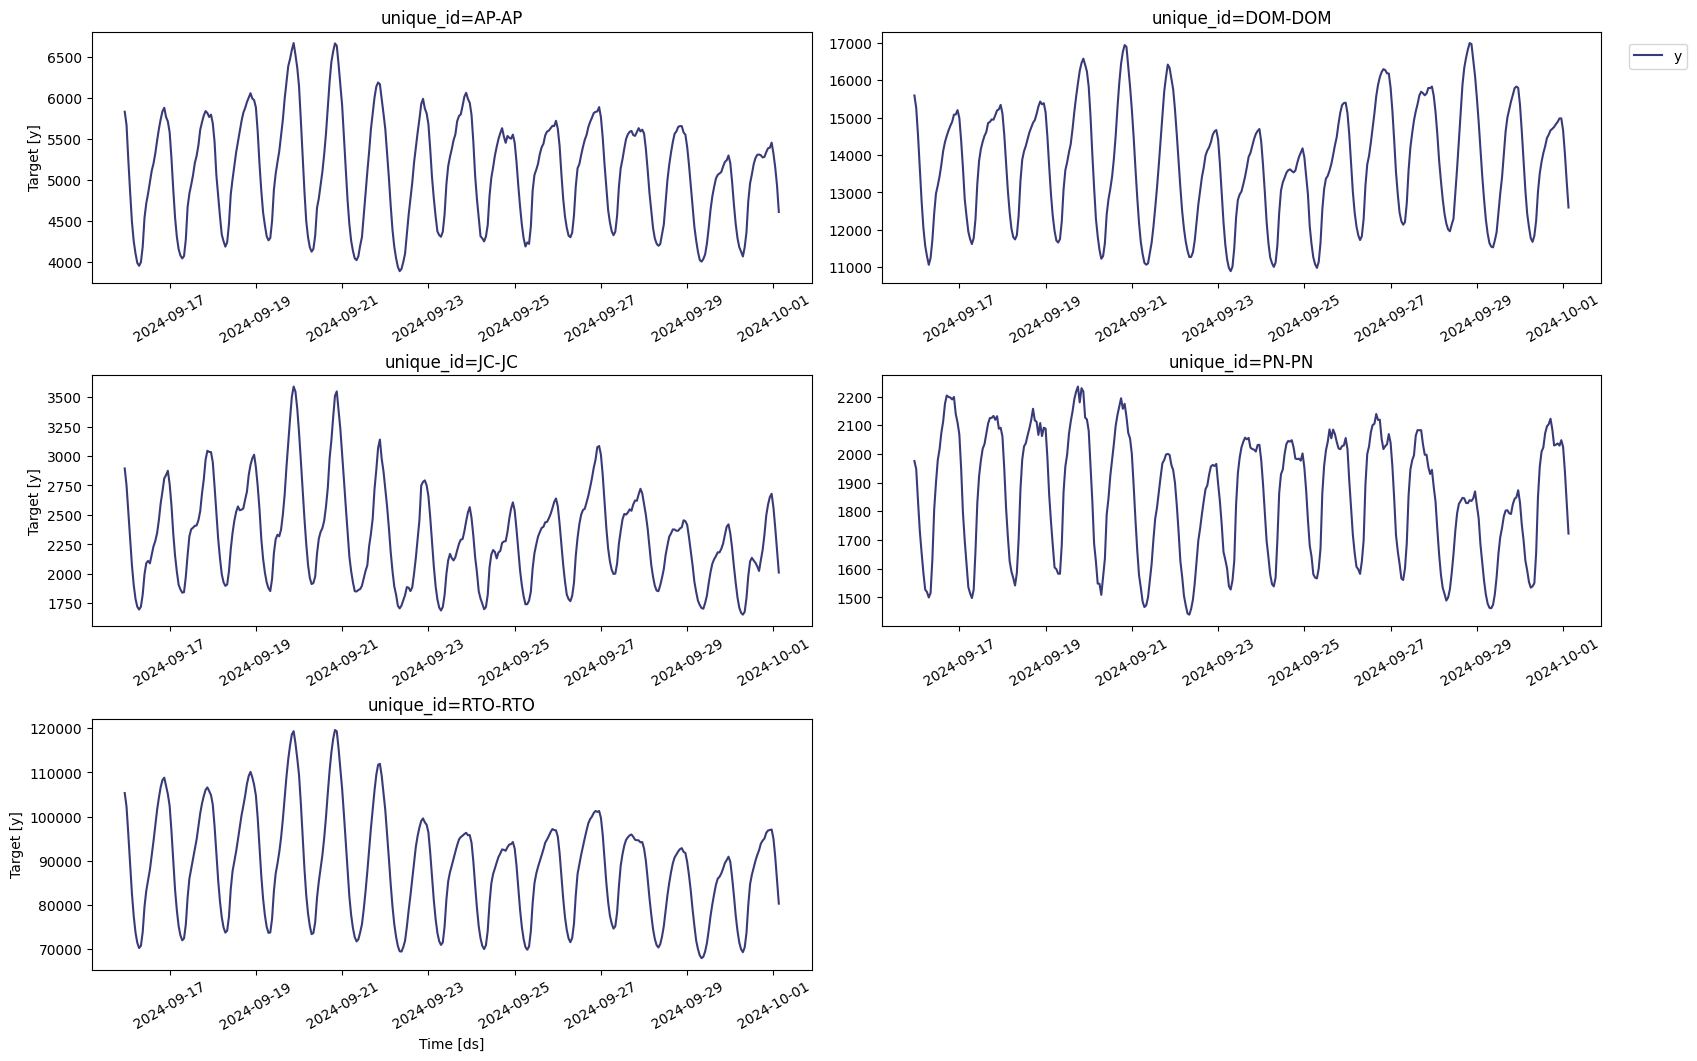

In [ ]:
nixtla_client.plot(
    df,
    max_insample_length=365,
)

In [ ]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 4 days (96 *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)

<ipython-input-7-1c474d0b2206>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 42 days (1008 * 1 day/24h)


In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

Time (TimeGPT): 3.4403493404388428


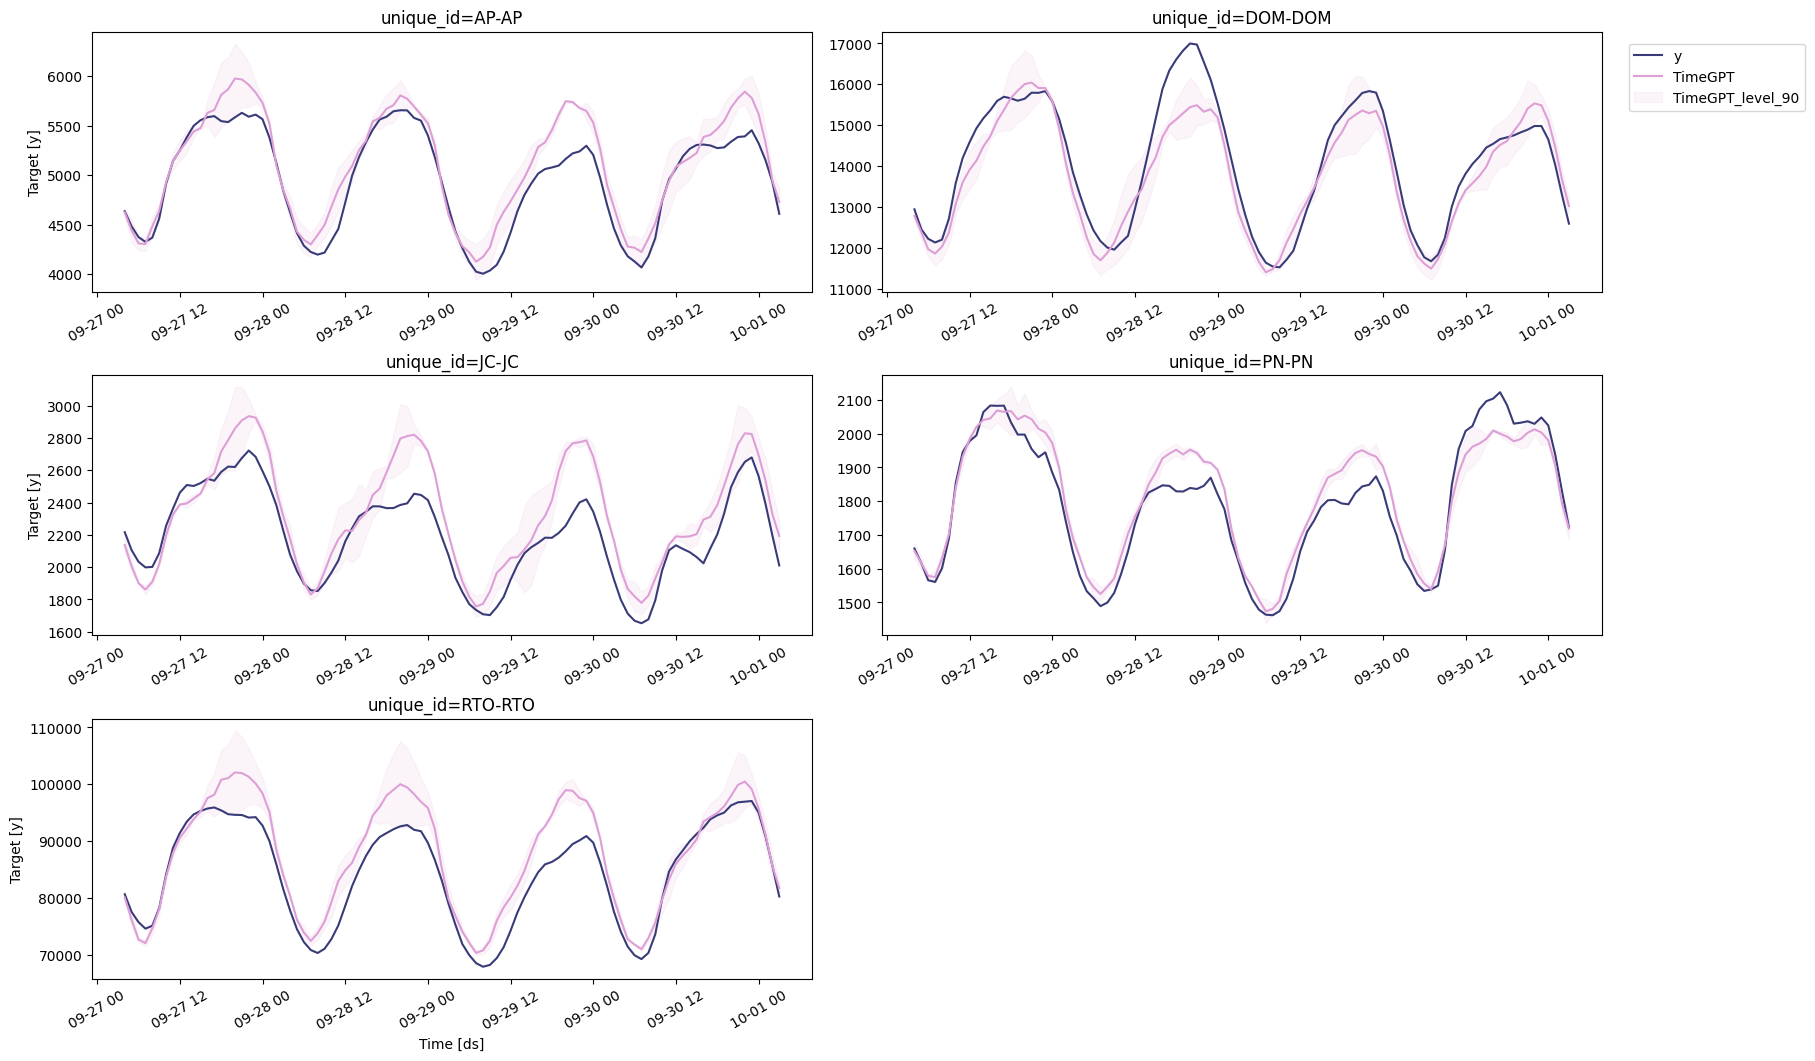

In [ ]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [ ]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

,TimeGPT
metric,
mae,882.638684
smape,0.019971
